In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
path_to_file = 'evgenyi_onegin.txt'
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
text = text + text

In [3]:
vocab = sorted(set(text))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[c] for c in text])

In [4]:
seq_length = 100
examples_per_epoch = len(text) // (seq_length + 1)
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [5]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    
    return input_text, target_text

In [6]:
dataset = sequences.map(split_input_target)

In [7]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data: ', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                         '
Target data:  'лександр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '


In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

In [9]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [10]:
vocab_size = len(vocab)
embedding_dim = 128
rnn_units = 1024

In [11]:
class RNNgenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super(RNNgenerator, self).__init__()
        
        self.emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
                                 
        self.gru1 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')

        self.gru2 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')
        self.gru3 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')

        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, x):
        emb_x = self.emb(x)
        x = self.gru1(emb_x)
        x = self.gru2(x)
        x = self.gru3(x)
        x = self.dense(x)
        
        return x

In [12]:
model = RNNgenerator(vocab_size,
                     embedding_dim,
                     rnn_units=rnn_units
                     )

In [13]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [14]:
model.compile(optimizer='adam', loss=loss, metrics='accuracy')

In [15]:
checkpoint_dir = './RNN_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=5,
                                save_weights_only=True)

In [16]:
EPOCHS = 3

In [17]:
%%time

history = model.fit(dataset,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback]
                   )

Epoch 1/3
88/88 [==============================] - 556s 6s/step - loss: 1.9296 - accuracy: 0.5624
Epoch 2/3
88/88 [==============================] - 779s 9s/step - loss: 1.4127 - accuracy: 0.6091
Epoch 3/3
88/88 [==============================] - 790s 9s/step - loss: 1.2875 - accuracy: 0.6324
CPU times: total: 3h 13min 33s
Wall time: 35min 24s


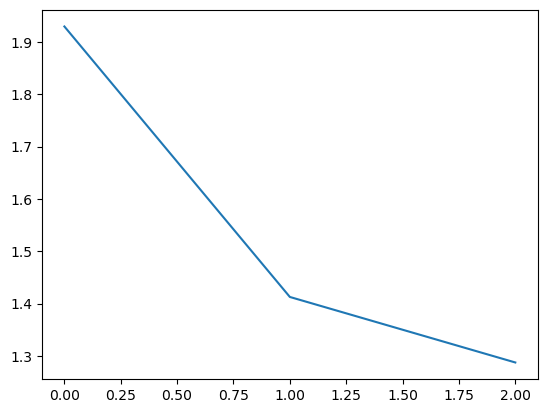

In [18]:
plt.plot(history.history['loss'])
plt.show()

In [19]:
tf.train.latest_checkpoint(checkpoint_dir)

'./RNN_checkpoints\\ckpt_3'

In [20]:
model = RNNgenerator(vocab_size, embedding_dim, rnn_units)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [21]:
num_generate = 500
temperature = 1

In [22]:
def generate_text(model, start_string):
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    model.reset_states()
    
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [23]:
text_ = generate_text(model, start_string=u"Мне памятно другое время")
print(text_)

Мне памятно другое время)хдо,                беежт,                       но)нуЯ
    Ны,          ВЗу         з{;      Ил  Н'8льо
                          йлЬ
    ,
  Ст7шlхел?                               Втли                 кне                     во
      к               
 стamk8, Vя
                  к,
                       И
   в,
 Ою
      Оз?
    б4nьв       Опж1у                       ДаВедадэни   Окрт.   Емама; Зу
   Ч?             Пе
          слe5ь,
              вм ПEw}         Бе  Кю  фI4Шmаме,
      
